# **Which of the playing teams in NHL have better public support and what is the overall public opinion on a particular team?**



In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from emot.emo_unicode import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
#nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pandas_bokeh

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
data_files = r"Tweets"
team_tweets_df= pd.DataFrame()
team_tweets_df= pd.concat(map(pd.read_csv,glob.glob(os.path.join(data_files,'Team*.csv'))), ignore_index= True)
team_tweets_df.to_csv("Team_Tweets_NHL.csv", index = False)
team_tweets_df.drop_duplicates(inplace=True)

In [4]:
team_tweets_df.head(10)

,Team,Date,Tweet
0,Boston Bruins,2022-03-25 21:31:26+00:00,@PowellAnalytics Bobby Orr. Boston Bruins.
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston..."
4,Boston Bruins,2022-03-25 21:13:41+00:00,RT @BR_Athletics_MA: Huge congratulations to J...
5,Boston Bruins,2022-03-25 21:10:22+00:00,How DeBrusk feels about staying with Bruins de...
6,Boston Bruins,2022-03-25 21:09:36+00:00,Bruins' failure to add forward depth at trade ...
7,Boston Bruins,2022-03-25 21:09:23+00:00,"Bruins improved at trade deadline, but path to..."
8,Boston Bruins,2022-03-25 21:09:01+00:00,Bruins cement status as legit contender with s...
9,Boston Bruins,2022-03-25 21:07:43+00:00,RT @BitSler: 🏒#NHL in 15 min 🏒\n\nBET NOW ➡️ h...


# Tweets cleaning

Cleaning is an important step before performing text analysis. Before performing sentiment analysis, we used regular expressions to remove hyperlinks, hashtags, mentions of other twitter users starting with ‘@’, retweets starting with ‘RT’ and emojis.

In [5]:
#removing hyoerlinks
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'https?:\/\/.*[\r\n]*', '').str.strip()

#remove # and @ from tweets
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'@\w+|#\w+|RT|', '').str.strip()

In [6]:
# Removing Emojis
def handle_emojis(tweet):
    for emot in UNICODE_EMOJI:
        tweet = tweet.replace(emot, "")
    return tweet

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(handle_emojis)

# Sentiment Stats of each team

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER is used to quantify how much positive or negative emotion the text has.Here, SentimentIntensityAnalyzer() is an object and polarity_scores method returns a dict having positive, negative, neutral and compound scores. The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text. For our case, we concluded that the tweets with compound scores between 0.5 and 1 are positive, -0.5 and -1 as negative and remaining as neutral.


In [7]:
team_names = team_tweets_df["Team"].unique()
analyzer = SentimentIntensityAnalyzer()
pd.options.mode.chained_assignment = None

Team_arr = []
positive_scores = []
negative_scores = []
neutral_scores = []

def determine_polarity(tweet):
    pol_scores = analyzer.polarity_scores(tweet) 
    compound_score = pol_scores["compound"]
    if compound_score >= 0.5:
        return "positive"
    elif compound_score <= -0.5:
        return "negative"
    else:
        return "neutral"
team_tweets_df1 = pd.DataFrame()    
for team in team_names:
    curr_team_df = team_tweets_df.loc[team_tweets_df["Team"] == team]
    curr_team_df["polarity"] = curr_team_df["Tweet"].apply(determine_polarity)
    team_tweets_df1 = team_tweets_df1.append(curr_team_df)
    pos_num = curr_team_df[curr_team_df["polarity"]== "positive"].count()["Tweet"]
    neg_num = curr_team_df[curr_team_df["polarity"]== "negative"].count()["Tweet"]
    neu_num = curr_team_df[curr_team_df["polarity"]== "neutral"].count()["Tweet"]
    
    Team_arr.append(team)
    positive_scores.append(pos_num)
    negative_scores.append(neg_num)
    neutral_scores.append(neu_num)
    
    print("\n=========== ",team ," Tweets Sentiment Stats: =================")
    print("Positive Tweets: ", pos_num)
    print("Negative Tweets: ", neg_num)
    print("Neutral Tweets:  ", neu_num)

Team_sentiment_stats_df = pd.DataFrame({"Team" : Team_arr,
                              "Positive_tweet" : positive_scores,
                              "Negative_tweet" : negative_scores,
                              "Neutral_tweet" : neutral_scores
                                       })
print(Team_sentiment_stats_df)

Team_sentiment_stats_df.to_csv('Teams_sentiment.csv')


===========  Boston Bruins  Tweets Sentiment Stats: =================
Positive Tweets:  1027
Negative Tweets:  231
Neutral Tweets:   2741

===========  Buffalo Sabres  Tweets Sentiment Stats: =================
Positive Tweets:  1327
Negative Tweets:  131
Neutral Tweets:   2275

===========  Detroit Red Wings  Tweets Sentiment Stats: =================
Positive Tweets:  725
Negative Tweets:  204
Neutral Tweets:   2538

===========  Florida Panthers  Tweets Sentiment Stats: =================
Positive Tweets:  995
Negative Tweets:  117
Neutral Tweets:   2693

===========  Montreal Canadiens  Tweets Sentiment Stats: =================
Positive Tweets:  730
Negative Tweets:  125
Neutral Tweets:   2864

===========  Ottawa Senators  Tweets Sentiment Stats: =================
Positive Tweets:  713
Negative Tweets:  136
Neutral Tweets:   2605

===========  Tampa Bay Lightning  Tweets Sentiment Stats: =================
Positive Tweets:  991
Negative Tweets:  198
Neutral Tweets:   2601

==========

In [8]:
team_tweets_df1.head(5)

,Team,Date,Tweet,polarity
0,Boston Bruins,2022-03-25 21:31:26+00:00,Bobby Orr. Boston Bruins.,neutral
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...,neutral
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...,neutral
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston...",neutral
4,Boston Bruins,2022-03-25 21:13:41+00:00,: Huge congratulations to Justin Peters who wi...,positive


In [9]:
data_senti = Team_sentiment_stats_df[['Team','Positive_tweet','Negative_tweet']]
data_senti.set_index('Team', inplace=True)
data_senti['Negative_tweet'] = data_senti['Negative_tweet'] * (-1)
#data_senti.sort_values(by = "Positive_tweet", inplace = True, ascending = True)
#data_senti

In [10]:
pandas_bokeh.output_notebook()

In [11]:

#from plot_bokeh import barh
data_senti.plot_bokeh.barh(title='Fans Sentiment towards NHL Teams')
data_senti.to_csv("Team_Sentiments.csv")

# Topic Modelling - LDA and LSI

A Topic Model is a type of statistical model for discovering the abstract “topics” that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

Latent Semantic Indexing, also known as latent semantic analysis, is a mathematical practice that helps classify and retrieve information on particular key terms and concepts using singular value decomposition (SVD).


In [12]:
#remove punctuation
team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].str.replace('[{}]'.format(string.punctuation), '')

In [13]:
#remove stop words
import nltk
nltk.download('stopwords')
stop_wrds = stopwords.words('english')

def stop_word_removal(tweet):
    return ' '.join([word for word in tweet.split() if word not in stop_wrds])

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(stop_word_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#tokenization
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True)

def tokenization(tweet):
    token_sent = tokenizer.tokenize(tweet)
    return token_sent

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(tokenization)
# team_tweets_df.to_csv('check.csv', index = False)

In [15]:
#lemmatization
import spacy 
def lemmatization(texts, team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    split_team = str.lower(team_name).split()
    split_team.append(split_team[-1][:-1])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.lemma_ not in split_team) and (len(token.lemma_) > 3)]))
    return texts_out

nlp = spacy.load("en_core_web_sm")
#keeping only Noun, Adj, Verb, Adverb
positive_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Positive_tweet"].idxmax()]["Team"]
positive_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == positive_team_name]
positive_team_df["Tweet"] = lemmatization(positive_team_df["Tweet"], positive_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
positive_team_df.head(5)

,Team,Date,Tweet,polarity
500,Buffalo Sabres,2022-03-25 22:33:41+00:00,,neutral
501,Buffalo Sabres,2022-03-25 22:30:03+00:00,free pick capital preview prediction,positive
502,Buffalo Sabres,2022-03-25 22:28:24+00:00,today pick capital pick available,neutral
503,Buffalo Sabres,2022-03-25 22:26:21+00:00,roll month keep trend tonight,neutral
504,Buffalo Sabres,2022-03-25 22:25:56+00:00,more tonight game capital ovechkin dominance y...,neutral


In [16]:
#Hyperparameter tuning for LDA model
def lda_hyperparameter(team_df):
  vectorizer = CountVectorizer(analyzer='word',       
                               min_df=10,                        
                               stop_words='english',             
                               lowercase=True,                   
                               #ngram_range=(1, 2)
                              )

  data_vectorized = vectorizer.fit_transform(positive_team_df["Tweet"])

  #Checking the sparsity of the data
  data_dense = data_vectorized.todense()
  print("sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
  # Define Search Param
  search_params = {'n_components': [3, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

  # Init the Model
  lda = LatentDirichletAllocation()

  # Init Grid Search Class
  model = GridSearchCV(lda, param_grid=search_params)

  # Do the Grid Search
  model.fit(data_vectorized)

  # Best Model
  best_lda_model = model.best_estimator_

  # Model Parameters
  print("Best Model's Params: ", model.best_params_)

  # Log Likelihood Score
  print("Best Log Likelihood Score: ", model.best_score_)

  # Perplexity
  print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

  n_topics = [3, 10, 15, 20, 25, 30]
  #print(model.cv_results_)
  scores_mean = model.cv_results_['mean_test_score'].tolist()
  print(scores_mean)
  log_likelyhoods_5 = scores_mean[0:6]
  log_likelyhoods_7 = scores_mean[6:12]
  log_likelyhoods_9 = scores_mean[12:18]

  # Show graph
  plt.figure(figsize=(12, 8))
  plt.plot(n_topics, log_likelyhoods_5, label='0.5')
  plt.plot(n_topics, log_likelyhoods_7, label='0.7')
  plt.plot(n_topics, log_likelyhoods_9, label='0.9')
  plt.title("Choosing Optimal LDA Model")
  plt.xlabel("Num Topics")
  plt.ylabel("Log Likelyhood Scores")
  plt.legend(title='Learning decay', loc='best')
  plt.show()

  return best_lda_model, data_vectorized, vectorizer 

sparsity:  1.0254974064242748 %
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -16262.061427087165
Model Perplexity:  181.611962031541
[-16276.35563031392, -17342.707440981212, -17916.961236145195, -18302.20623825322, -18782.828628019743, -19061.090766184054, -16292.9434513673, -17347.892184817254, -17962.764627664892, -18312.446103595823, -18734.808465177157, -19127.191849962768, -16262.061427087165, -17362.772044741338, -18002.42963768444, -18199.818622682338, -18611.181545121428, -19180.2937628074]


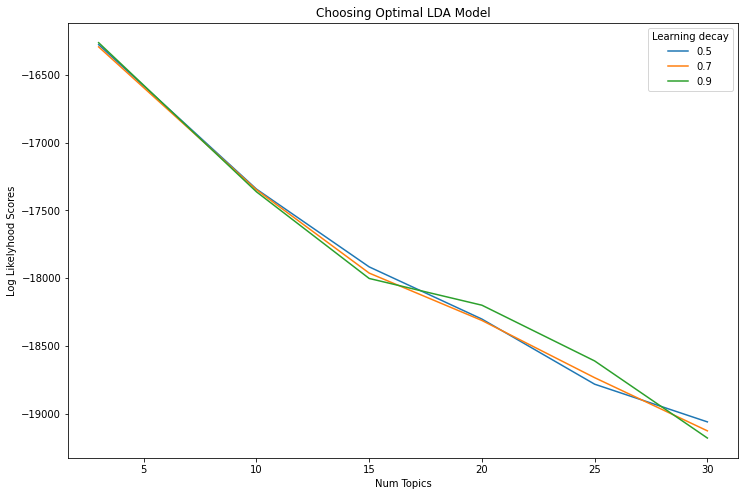

In [17]:
#Best LDA model for positive team
best_lda_model, data_vectorized, vectorizer = lda_hyperparameter(positive_team_df)

In [18]:
#visualization for LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  40.010554
1      -387.996002  -373.316162       2        1  30.234262
2     -2184.745605   -60.565800       3        1  29.755184, topic_info=          Term        Freq       Total Category  logprob  loglift
315       want  397.000000  397.000000  Default  30.0000  30.0000
64      energy  357.000000  357.000000  Default  29.0000  29.0000
145  legendary  323.000000  323.000000  Default  28.0000  28.0000
121      honor  321.000000  321.000000  Default  27.0000  27.0000
94        game  337.000000  337.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
137       know   52.711962   72.678419   Topic3  -4.3031   0.8910
194       pick   48.736709   75.606481   Topic3  -4.3815   0.7731
244      score   76.135425  221.469209   Topic3  -3.9355   0.1444
42        come   36.336335   73.725981   Topic3  -4.6752   0.5046
291       time   38.679589  126.375893   Topic3  -4.6127   0.0282

[149 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.957718     afraid
6         2  0.985774      ahead
9         1  0.993828   announce
11        3  0.951318    apparel
13        3  0.966560  available
...     ...       ...        ...
316       3  0.289871      watch
327       1  0.035080       year
327       2  0.005011       year
327       3  0.962182       year
328       1  0.967934  yesterday

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Tage Thompson's recent performance
- Topic 3 - Fan's support and celebration over wins.

In [19]:
#showing first 15 topics for positive team
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,season,goal,capital,score,play,tonight,night,shootout,start,today,loss,make,watch,return
Topic 1,want,energy,legendary,honor,team,trade,playoff,make,sport,join,talk,head,time,excited,speak
Topic 2,team,year,good,tage,penguin,point,throwback,bring,support,panther,preview,look,forward,lift,sale


Text(0.5, 1.0, 'Segregation of Topic Clusters')

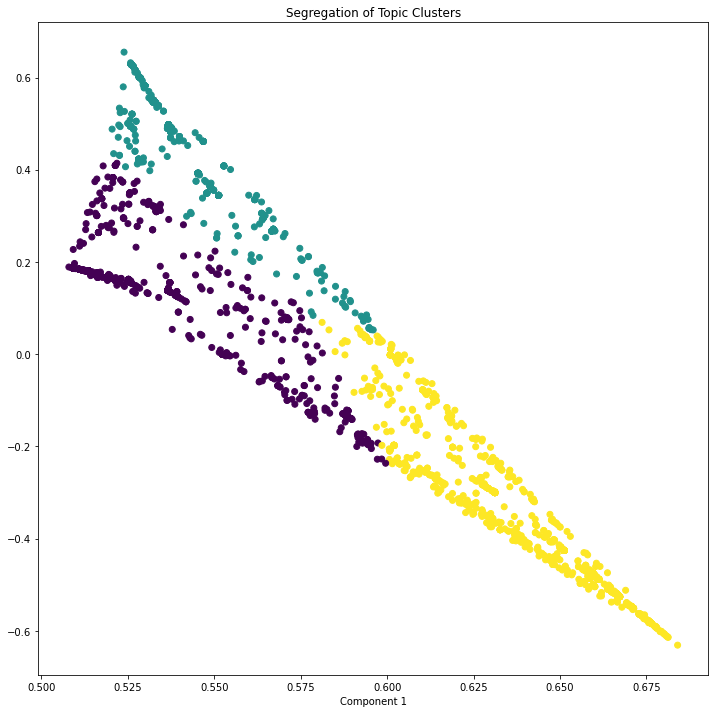

In [20]:
#visualize the clusters of documents in a 2D space
from sklearn.cluster import KMeans
lda_output = best_lda_model.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [21]:
#LSI model for positive team
import gensim
import gensim.corpora as corpora
from pprint import pprint

data_lemma = positive_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.516*"want" + 0.502*"energy" + 0.490*"legendary" + 0.490*"honor" + '
  '0.023*"team" + 0.015*"love" + 0.012*"bill" + 0.012*"sport" + 0.011*"join" + '
  '0.010*"excited"'),
 (1,
  '0.512*"team" + 0.330*"game" + 0.246*"back" + 0.227*"throwback" + '
  '0.227*"bring" + 0.214*"support" + 0.198*"sale" + 0.194*"throw" + '
  '0.183*"capital" + 0.149*"score"'),
 (2,
  '0.427*"game" + -0.280*"throwback" + -0.279*"bring" + 0.263*"capital" + '
  '-0.254*"support" + -0.253*"sale" + -0.247*"throw" + -0.236*"team" + '
  '-0.224*"back" + 0.185*"goal"')]


The LSI model's results are similar to LDA's.

In [22]:
#keeping only Noun, Adj, Verb, Adverb
negative_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Negative_tweet"].idxmax()]["Team"]
negative_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == negative_team_name]
negative_team_df = negative_team_df[negative_team_df["polarity"] == "negative"]
negative_team_df["Tweet"] = lemmatization(negative_team_df["Tweet"], negative_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_team_df.head(5)

,Team,Date,Tweet,polarity
9002,New Jersey Devils,2022-03-25 22:47:56+00:00,blackdevil just follow also nickname black sur...,negative
9003,New Jersey Devils,2022-03-25 22:41:47+00:00,request,negative
9010,New Jersey Devils,2022-03-25 21:47:22+00:00,last game play exemplify season turn early def...,negative
9011,New Jersey Devils,2022-03-25 21:41:27+00:00,capital,negative
9014,New Jersey Devils,2022-03-25 20:38:47+00:00,,negative


sparsity:  1.0254974064242748 %
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -16265.349720109418
Model Perplexity:  175.88700740355503
[-16283.709975910548, -17446.497981791756, -17954.96854992805, -18378.925448100847, -18752.80933614316, -19236.68555236057, -16338.620752667732, -17450.287833486636, -17951.221194874746, -18323.112896935345, -18717.847899583743, -19166.115121650073, -16265.349720109418, -17426.692133265107, -17888.69180535876, -18212.805874605845, -18871.05117460894, -19016.069336376015]


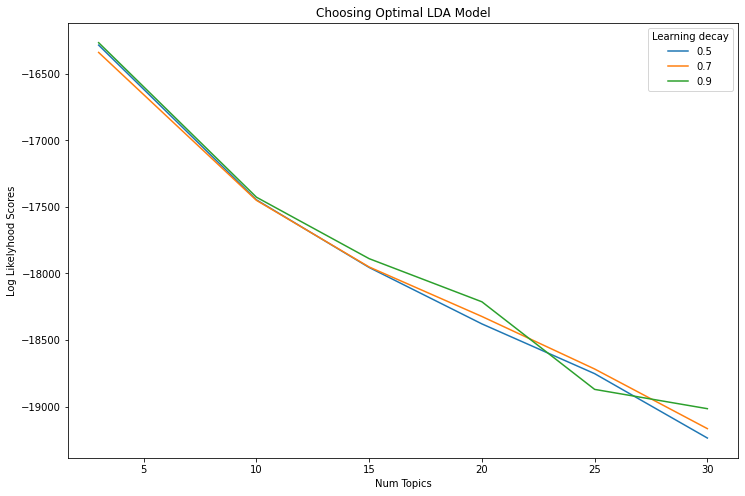

In [23]:
#best lda model for negative team
best_lda_model, data_vectorized, vectorizer = lda_hyperparameter(negative_team_df)

In [24]:
#LDA visualization for negative team
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  36.113628
1      -387.996002  -373.316162       2        1  35.645929
2     -2184.745605   -60.565800       3        1  28.240443, topic_info=          Term        Freq       Total Category  logprob  loglift
315       want  402.000000  402.000000  Default  30.0000  30.0000
64      energy  362.000000  362.000000  Default  29.0000  29.0000
145  legendary  327.000000  327.000000  Default  28.0000  28.0000
121      honor  325.000000  325.000000  Default  27.0000  27.0000
94        game  340.000000  340.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
245     season   58.159678  191.338178   Topic3  -4.1525   0.0736
264       star   33.190901   47.582139   Topic3  -4.7134   0.9042
89        free   33.062941   56.938231   Topic3  -4.7173   0.7209
316      watch   34.180599   91.005451   Topic3  -4.6841   0.2852
280       team   33.126775  382.042631   Topic3  -4.7154  -1.1808

[154 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9         3  0.982640   announce
17        1  0.985571       bear
18        1  0.982329       beat
20        3  0.955995       best
24        2  0.995125      bring
...     ...       ...        ...
316       2  0.318662      watch
316       3  0.373604      watch
327       1  0.242064       year
327       2  0.757094       year
328       3  0.974698  yesterday

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Loss due to Jack Hughes injury.
- Topic 3 - Fan's support as well as criticism

In [25]:
#top 15 words per topic
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,score,goal,penguin,capital,tonight,tage,point,make,night,shootout,lift,celebrate,loss,start
Topic 1,team,year,play,good,throwback,bring,panther,support,playoff,look,forward,time,sale,come,know
Topic 2,want,energy,legendary,honor,trade,preview,join,return,pick,source,talk,season,sport,announce,northeastern


Text(0.5, 1.0, 'Segregation of Topic Clusters')

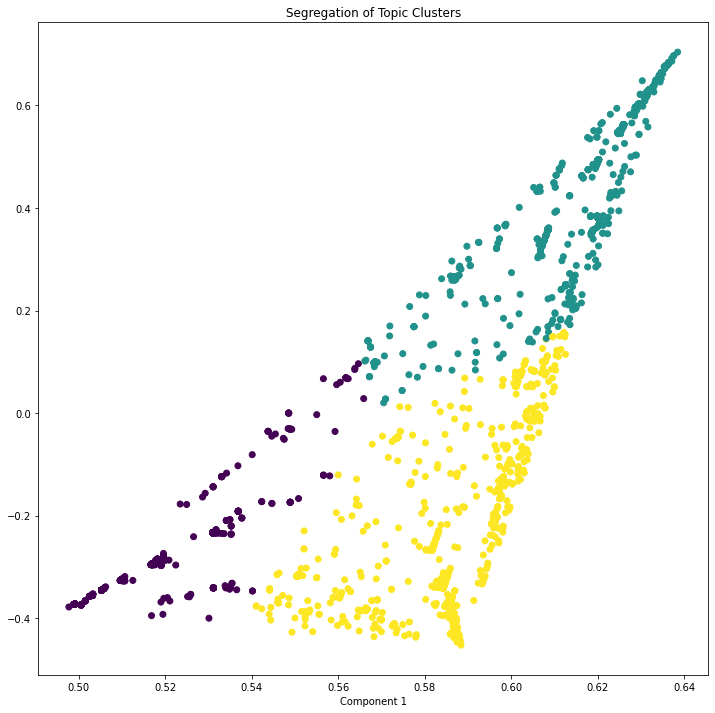

In [26]:
#visualize the clusters of documents in a 2D space - negative team
lda_output = best_lda_model.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [27]:
#LSI model for negative team
data_lemma = negative_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.432*"score" + 0.417*"goal" + 0.356*"history" + 0.355*"become" + '
  '0.355*"ever" + 0.354*"player" + 0.354*"abuse" + 0.048*"defeat" + '
  '0.025*"beat" + 0.025*"canuck"'),
 (1,
  '0.513*"panther" + 0.511*"defeat" + 0.475*"comeback" + 0.470*"complete" + '
  '0.060*"flame" + 0.058*"game" + -0.039*"abuse" + -0.039*"player" + '
  '-0.039*"ever" + -0.038*"become"'),
 (2,
  '0.437*"lose" + 0.376*"playoff" + 0.376*"eliminate" + 0.376*"contention" + '
  '0.367*"regulation" + 0.342*"tonight" + 0.311*"montreal" + 0.070*"canuck" + '
  '0.061*"second" + -0.055*"complete"')]


The LSI model's results are similar to that of LDA's